# MS016 Preprocess
01/10/2024

In [1]:
import numpy as np
import mne
from glob import glob
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns
from scipy.stats import zscore, linregress, ttest_ind, ttest_rel, ttest_1samp
import pandas as pd
from mne.preprocessing.bads import _find_outliers
import os 
import joblib
import emd
import re

import warnings
warnings.filterwarnings('ignore')

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import sys
sys.path.append('/Users/alexandrafink/Documents/GitHub/afink_lfp_pipeline/LFPAnalysis/')

In [4]:
from LFPAnalysis import lfp_preprocess_utils, sync_utils, analysis_utils, nlx_utils

In [5]:
# Specify root directory for un-archived data and results 
base_dir = '/Users/alexandrafink/Documents/GraduateSchool/SaezLab/SWB/'
anat_dir = f'{base_dir}anat_recons/recon_labels/'
neural_dir = f'{base_dir}ephys_analysis/data/'
behav_dir = f'{base_dir}behavior_analysis/behavior_preprocessed/'

subj_id = 'MS016'
subj_format = ['edf']
subj_site = ['MSSM']


# Make mne_data


### Load and resample data


In [27]:
edf_files = glob(f'{neural_dir}{subj_id}/raw/*.edf')

mne_data = mne.io.read_raw_edf(edf_files[0], preload=True)


In [28]:
mne_data

<RawEDF | MS016_SWB.edf, 276 x 2351040 (2295.9 s), ~4.83 GB, data loaded>

In [29]:
mne_data.ch_names

['LmOIF1',
 'LmOIF2',
 'LmOIF3',
 'LmOIF4',
 'LmOIF5',
 'LmOIF6',
 'LmOIF7',
 'LmOIF8',
 'LmOIF9',
 'LaCaS1',
 'LaCaS2',
 'LaCaS3',
 'LaCaS4',
 'LaCaS5',
 'LaCaS6',
 'LaCaS7',
 'LaCaS8',
 'LaCaS9',
 'LaCaS10',
 'LaCaS11',
 'LaCaS12',
 'LAgIT1',
 'LAgIT2',
 'LAgIT3',
 'LAgIT4',
 'LAgIT5',
 'LAgIT6',
 'LAgIT7',
 'LAgIT8',
 'LAgIT9',
 'LAgIT10',
 'LAgIT11',
 'LAgIT12',
 'LHpIT1',
 'LHpIT2',
 'LHpIT3',
 'LHpIT4',
 'LHpIT5',
 'LHpIT6',
 'LHpIT7',
 'LHpIT8',
 'LHpIT9',
 'LHpIT10',
 'LILS21',
 'LILS22',
 'LILS23',
 'LILS24',
 'LILS25',
 'LILS26',
 'LmLS31',
 'LmLS32',
 'LmLS33',
 'LmLS34',
 'LmLS35',
 'LmLS36',
 'LmLS37',
 'LmLS38',
 'C58',
 'C59',
 'C60',
 'C61',
 'C62',
 'C63',
 'C64',
 'LILS11',
 'LILS12',
 'LILS13',
 'LILS14',
 'LILS15',
 'LILS16',
 'LILS17',
 'LILS18',
 'RAgIT1',
 'RAgIT2',
 'RAgIT3',
 'RAgIT4',
 'RAgIT5',
 'RAgIT6',
 'RAgIT7',
 'RAgIT8',
 'RAgIT9',
 'RHpIT1',
 'RHpIT2',
 'RHpIT3',
 'RHpIT4',
 'RHpIT5',
 'RHpIT6',
 'RHpIT7',
 'RHpIT8',
 'RHpIT9',
 'RHpIT10',
 'RaCaS1',
 

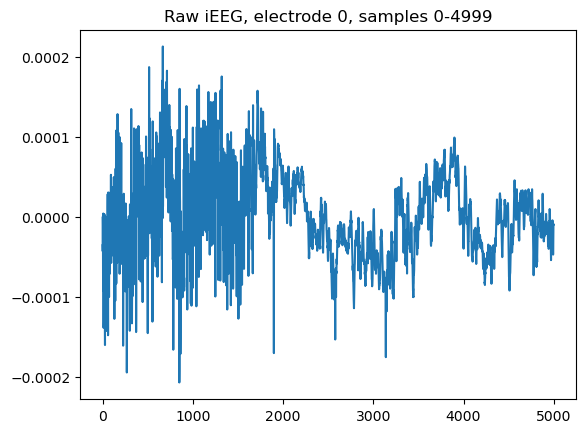

In [30]:
# Sanity check one channel data
plt.plot(mne_data._data[0,:4999])
plt.title("Raw iEEG, electrode 0, samples 0-4999")
plt.show()

### Resampling data 

In [31]:
#resampling if patient is not sampled at 512
resample_sr = 500
mne_data.resample(sfreq=resample_sr, npad='auto', n_jobs=-1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:    9.4s
[Parallel(n_jobs=-1)]: Done 276 out of 276 | elapsed:   16.7s finished


<RawEDF | MS016_SWB.edf, 276 x 1147969 (2295.9 s), ~2.36 GB, data loaded>

### Photodiode
- examine photodiode 
- save out before resampling/notch filtering *unless nlx - then you have to resample first 

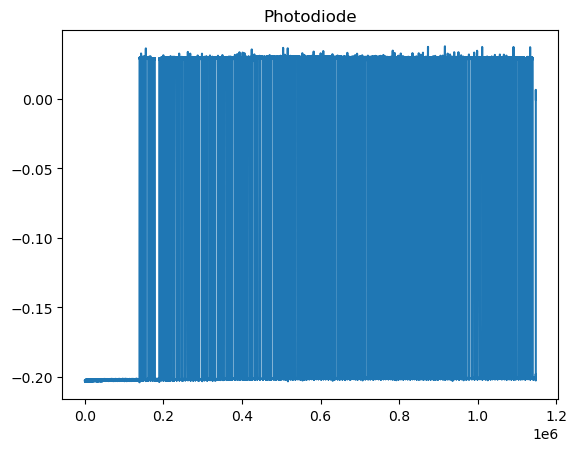

In [11]:
# Sanity check the photodiode
trig_ix = mne_data.ch_names.index("DC1")
plt.plot(mne_data._data[trig_ix])
plt.title("Photodiode")
plt.show()

In [12]:
mne_data.save(f'{neural_dir}{subj_id}/photodiode.fif', picks='DC1', overwrite=True)

In [32]:
mne_data.drop_channels(['DC1'])

<RawEDF | MS016_SWB.edf, 275 x 1147969 (2295.9 s), ~2.35 GB, data loaded>

### Notch filter line noise

In [33]:
mne_data.info['line_freq'] = 60
# Notch out 60 Hz noise and harmonics 
mne_data.notch_filter(freqs=(60, 120, 180, 240))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 275 out of 275 | elapsed:    6.8s finished


<RawEDF | MS016_SWB.edf, 275 x 1147969 (2295.9 s), ~2.35 GB, data loaded>

### Anatomical Localization

In [34]:
### Rename channels to be lowercase before anatomical localization
new_name_dict = {x:x.replace(" ", "").lower() for x in mne_data.ch_names}
mne_data.rename_channels(new_name_dict)

<RawEDF | MS016_SWB.edf, 275 x 1147969 (2295.9 s), ~2.35 GB, data loaded>

In [35]:
# Load the electrode localization data
anat_file = glob(f'{anat_dir}{subj_id}_labels.csv')[0]
elec_locs = pd.read_csv(anat_file)
# Sometimes there's extra columns with no entries: 
elec_locs = elec_locs[elec_locs.columns.drop(list(elec_locs.filter(regex='Unnamed')))]

elec_locs

,label,BN246label,x,y,z,mni_x,mni_y,mni_z,gm,NMM,Anat,AnatMacro,BN246,YBA_1,ManualExamination,Notes
0,LaCas1,A32sg_L,-4.195963,38.755833,1.548926,-4.923962,30.522125,-7.317985,Gray,Left ACgG anterior cingulate gyrus,Area s24,L ACC,L CG,Left cingulate gyrus D,NaN,NaN
1,LaCas2,A24rv_L,-6.593655,39.555832,5.546539,-7.498945,32.166524,-2.505895,White,Left ACgG anterior cingulate gyrus,Unknown,L ACC,L CG,Left cingulate gyrus D,WM,NaN
2,LaCas3,Unknown,-8.991346,40.755832,9.544152,-10.170427,34.069446,2.265049,White,Left Cerebral White Matter,Unknown,Unknown,Unknown,Unknown,WM,NaN
3,LaCas4,Unknown,-11.389038,41.955831,13.941527,-12.808619,36.020665,7.462891,White,Left Cerebral White Matter,Unknown,Unknown,Unknown,Unknown,WM,NaN
4,LaCas5,Unknown,-13.786730,43.155830,17.939140,-15.421547,37.883783,12.121384,White,Left Cerebral White Matter,Unknown,Unknown,Unknown,Unknown,WM,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149,llem14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Unknown,OOB,NaN
150,llem15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Unknown,OOB,NaN
151,llem16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Unknown,OOB,NaN
152,llem17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Unknown,OOB,NaN


In [36]:
list(elec_locs.label)

['LaCas1',
 'LaCas2',
 'LaCas3',
 'LaCas4',
 'LaCas5',
 'LaCas6',
 'LaCas7',
 'LaCas8',
 'LaCas9',
 'LaCas10',
 'LaCas11',
 'LaCas12',
 'LAgIT1',
 'LAgIT2',
 'LAgIT3',
 'LAgIT4',
 'LAgIT5',
 'LAgIT6',
 'LAgIT7',
 'LAgIT8',
 'LAgIT9',
 'LAgIT10',
 'LAgIT11',
 'LAgIT12',
 'LaImM1',
 'LaImM2',
 'LaImM3',
 'LaImM4',
 'LaImM5',
 'LaImM6',
 'LaImM7',
 'LaImM8',
 'LaImM9',
 'LaImM10',
 'LaImM11',
 'LaImM12',
 'LaImM13',
 'LaImM14',
 'LaImM15',
 'LaImM16',
 'LHpIT1',
 'LHpIT2',
 'LHpIT3',
 'LHpIT4',
 'LHpIT5',
 'LHpIT6',
 'LHpIT7',
 'LHpIT8',
 'LHpIT9',
 'LHpIT10',
 'LILS1_1',
 'LILS1_2',
 'LILS1_3',
 'LILS1_4',
 'LILS1_5',
 'LILS1_6',
 'LILS1_7',
 'LILS1_8',
 'LILS2_1',
 'LILS2_2',
 'LILS2_3',
 'LILS2_4',
 'LILS2_5',
 'LILS2_6',
 'LmCmS1',
 'LmCmS2',
 'LmCmS3',
 'LmCmS4',
 'LmCmS5',
 'LmCmS6',
 'LmCmS7',
 'LmCmS8',
 'LmCmS9',
 'LmCmS10',
 'LMLS3_1',
 'LMLS3_2',
 'LMLS3_3',
 'LMLS3_4',
 'LMLS3_5',
 'LMLS3_6',
 'LMLS3_7',
 'LMLS3_8',
 'LmOlF1',
 'LmOlF2',
 'LmOlF3',
 'LmOlF4',
 'LmOlF5',
 'LmOl

In [37]:
anat_names = list(elec_locs.label.str.lower())
sum([ch not in mne_data.ch_names for ch in anat_names]) #if there are no missing channels, sum = 0. if sum >0, find the missing elecs
print([ch for ch in mne_data.ch_names if ch not in anat_names ]) #print extra channels in mne_data.ch_names and make sure none of them are neural channels (will be EEG etc.)

['lmoif1', 'lmoif2', 'lmoif3', 'lmoif4', 'lmoif5', 'lmoif6', 'lmoif7', 'lmoif8', 'lmoif9', 'lils21', 'lils22', 'lils23', 'lils24', 'lils25', 'lils26', 'lmls31', 'lmls32', 'lmls33', 'lmls34', 'lmls35', 'lmls36', 'lmls37', 'lmls38', 'c58', 'c59', 'c60', 'c61', 'c62', 'c63', 'c64', 'lils11', 'lils12', 'lils13', 'lils14', 'lils15', 'lils16', 'lils17', 'lils18', 'laims1', 'laims2', 'laims3', 'laims4', 'laims5', 'laims6', 'laims7', 'laims8', 'laims9', 'laims10', 'laims11', 'laims12', 'laims13', 'laims14', 'laims15', 'laims16', 'c120', 'c121', 'c122', 'c123', 'c124', 'c125', 'c126', 'c127', 'c128', 'c139', 'c140', 'c141', 'c142', 'c143', 'c144', 'c151', 'c152', 'c153', 'c154', 'c155', 'c156', 'fp1', 'f7', 't3', 't5', 'o1', 'f3', 'c3', 'p3', 'fp2', 'f8', 't4', 't6', 'o2', 'f4', 'c4', 'p4', 'fz', 'cz', 'pz', 'ekg1', 'ekg2', 'chest1', 'chest2', 'abs1', 'abs2', 'c190', 'c191', 'c192', 'c209', 'c210', 'c211', 'c212', 'c213', 'c214', 'c215', 'c216', 'c217', 'c218', 'c219', 'c220', 'c221', 'c222', '

In [38]:
new_mne_names, unmatched_names, unmatched_seeg = lfp_preprocess_utils.match_elec_names(mne_data.ch_names, elec_locs.label)


Number of electrodes in the mne file is greater than the number of electrodes in the localization file


In [39]:
unmatched_seeg #make sure there are no unmatched names


[]

In [40]:
new_name_dict = {x:y for (x,y) in zip(mne_data.ch_names, new_mne_names)}


In [41]:
new_name_dict #make sure this passes the eye test 


{'lmoif1': 'lmolf1',
 'lmoif2': 'lmolf2',
 'lmoif3': 'lmolf3',
 'lmoif4': 'lmolf4',
 'lmoif5': 'lmolf5',
 'lmoif6': 'lmolf6',
 'lmoif7': 'lmolf7',
 'lmoif8': 'lmolf8',
 'lmoif9': 'lmolf9',
 'lacas1': 'lacas1',
 'lacas2': 'lacas2',
 'lacas3': 'lacas3',
 'lacas4': 'lacas4',
 'lacas5': 'lacas5',
 'lacas6': 'lacas6',
 'lacas7': 'lacas7',
 'lacas8': 'lacas8',
 'lacas9': 'lacas9',
 'lacas10': 'lacas10',
 'lacas11': 'lacas11',
 'lacas12': 'lacas12',
 'lagit1': 'lagit1',
 'lagit2': 'lagit2',
 'lagit3': 'lagit3',
 'lagit4': 'lagit4',
 'lagit5': 'lagit5',
 'lagit6': 'lagit6',
 'lagit7': 'lagit7',
 'lagit8': 'lagit8',
 'lagit9': 'lagit9',
 'lagit10': 'lagit10',
 'lagit11': 'lagit11',
 'lagit12': 'lagit12',
 'lhpit1': 'lhpit1',
 'lhpit2': 'lhpit2',
 'lhpit3': 'lhpit3',
 'lhpit4': 'lhpit4',
 'lhpit5': 'lhpit5',
 'lhpit6': 'lhpit6',
 'lhpit7': 'lhpit7',
 'lhpit8': 'lhpit8',
 'lhpit9': 'lhpit9',
 'lhpit10': 'lhpit10',
 'lils21': 'lils2_1',
 'lils22': 'lils2_2',
 'lils23': 'lils2_3',
 'lils24': 'lils2

In [42]:
# Rename the mne data according to the localization data

mne_data.rename_channels(new_name_dict)

<RawEDF | MS016_SWB.edf, 275 x 1147969 (2295.9 s), ~2.35 GB, data loaded>

In [43]:
right_seeg_names = [i for i in mne_data.ch_names if i.startswith('r')]
left_seeg_names = [i for i in mne_data.ch_names if i.startswith('l')]
print(f'We have a total of {len(left_seeg_names)} left sEEG and {len(right_seeg_names)} right sEEG electrodes')
print(f'We have a total of {len(left_seeg_names) + len(right_seeg_names)} sEEG electrodes')



We have a total of 121 left sEEG and 31 right sEEG electrodes
We have a total of 152 sEEG electrodes


In [44]:
sEEG_mapping_dict = {f'{x}':'seeg' for x in left_seeg_names+right_seeg_names}
mne_data.set_channel_types(sEEG_mapping_dict)


<RawEDF | MS016_SWB.edf, 275 x 1147969 (2295.9 s), ~2.35 GB, data loaded>

In [45]:
drop_chans = list(set(mne_data.ch_names)^set(left_seeg_names+right_seeg_names))
mne_data.drop_channels(drop_chans) #number of chans should = number of seegs + 1 (photodiode)

<RawEDF | MS016_SWB.edf, 152 x 1147969 (2295.9 s), ~1.30 GB, data loaded>

In [46]:
# make montage (convert mm to m)

montage = mne.channels.make_dig_montage(ch_pos=dict(zip(elec_locs.label, 
                                                        elec_locs[['mni_x', 'mni_y', 'mni_z']].to_numpy(dtype=float)/1000)),
                                        coord_frame='mni_tal')

mne_data.set_montage(montage, match_case=False, on_missing='warn')

<RawEDF | MS016_SWB.edf, 152 x 1147969 (2295.9 s), ~1.30 GB, data loaded>

## Signal Cleaning 
Methods:
- Remove all channels that are obviously noise
- Be LIBERAL with bad labeling - these channels are NOT removed from the dataset, they are just NOT USED to rereference other channels. 
- This process is iterative depending on how TFRs look. 

In [47]:
lfp_preprocess_utils.detect_bad_elecs(mne_data, sEEG_mapping_dict)

['lacas12',
 'lacas7',
 'laimm15',
 'lham18',
 'lils1_7',
 'llem18',
 'lmcms3',
 'lmcms5',
 'lmcms6',
 'lmls3_3',
 'lmolf3',
 'lmolf5',
 'lmolf6',
 'lmolf9',
 'ragit1',
 'ragit6']

In [48]:
#this is just for my own personal info and to select how many channels to visualize at a time
ch_names = list(elec_locs.label.str.lower())
pattern = '[0-9]'
ch_names_no_num = [re.sub(pattern, '', i) for i in ch_names]
probe_names = np.unique(ch_names_no_num)

In [49]:
probe_names

array(['lacas', 'lagit', 'laimm', 'lham', 'lhpit', 'lils_', 'llem',
       'lles', 'llesma', 'lmcms', 'lmls_', 'lmolf', 'racas', 'ragit',
       'rhpit', 'ulmolf', 'uragit'], dtype='<U6')

In [50]:
probe_ch_counts = {} #need this to select channel number for visualization
for p in probe_names:
    c = ch_names_no_num.count(p)
    probe_ch_counts[p] = c

In [51]:
probe_ch_counts

{'lacas': 12,
 'lagit': 12,
 'laimm': 16,
 'lham': 8,
 'lhpit': 10,
 'lils_': 14,
 'llem': 8,
 'lles': 8,
 'llesma': 6,
 'lmcms': 10,
 'lmls_': 8,
 'lmolf': 9,
 'racas': 12,
 'ragit': 9,
 'rhpit': 10,
 'ulmolf': 1,
 'uragit': 1}

<IPython.core.display.Javascript object>


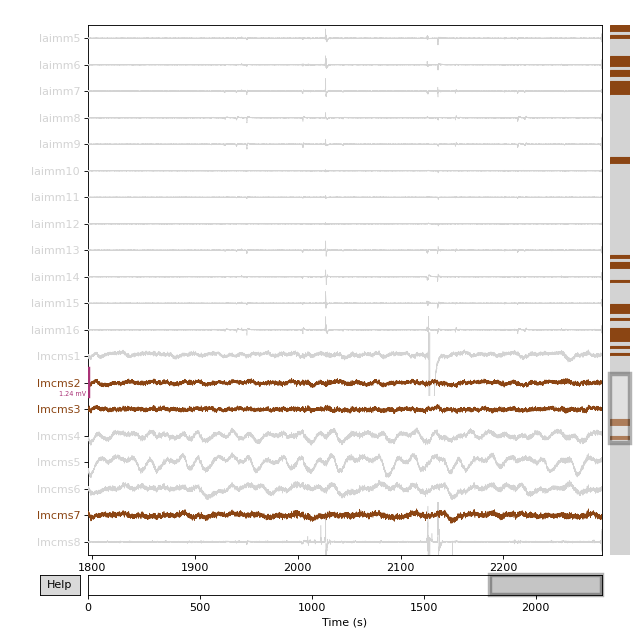

<IPython.core.display.Javascript object>


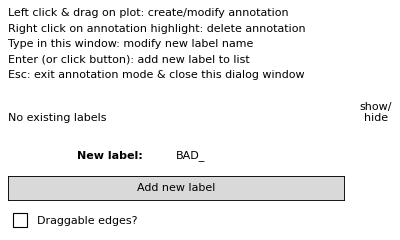

In [52]:
%matplotlib notebook 
fig = mne_data.plot(start=0, duration=500, n_channels=20, scalings=mne_data._data.max()/20)
fig.fake_keypress('a')

In [39]:
mne_data.info['bads']

['lmoif1',
 'lmoif2',
 'rmoif9',
 'lmoif12',
 'lmoif13',
 'rmoif1',
 'rmoif2',
 'rmoif3',
 'rmoif4',
 'rmoif5',
 'lacas10',
 'lacas9',
 'lacas8',
 'lacas1',
 'lacas6',
 'racas1',
 'racas2',
 'racas12',
 'laims1',
 'laims2',
 'laims3',
 'laims5',
 'raims2',
 'raims3',
 'raims4',
 'raims5',
 'raims1',
 'raims14',
 'lsif7',
 'lsif4',
 'lsif5',
 'raims11',
 'raims12',
 'raims10',
 'lpips12',
 'lpips11',
 'lagit1',
 'lagit2',
 'lagit8',
 'lagit9',
 'ragit1',
 'ragit6',
 'lagit10',
 'lagit7',
 'lhplt2',
 'lhplt3',
 'ragit9',
 'lhplt1',
 'lhplt10',
 'lhplt9',
 'lhplt8',
 'lhplt6',
 'lhplt7',
 'rhplt11',
 'lhplt11',
 'lhplt12',
 'rhplt1',
 'rhplt2',
 'rhplt3',
 'rhplt5',
 'rhplt8',
 'rhplt9',
 'rhplt10',
 'rhplt12']

In [40]:
#add manually for situations where raw data needs to be updated but manual bad channel inspection does not change 
mne_data.info['bads'] = ['lmoif1','lmoif2','rmoif9','lmoif12','lmoif13','rmoif1','rmoif2',
                         'rmoif3','rmoif4','rmoif5','lacas10','lacas9','lacas8','lacas1',
                         'lacas6','racas1','racas2','racas12','laims1','laims2','laims3',
                         'laims5','raims2','raims3','raims4','raims5','raims1','raims14',
                         'lsif7','lsif4','lsif5','raims11','raims12','raims10','lpips12',
                         'lpips11','lagit1','lagit2','lagit8','lagit9','ragit1','ragit6',
                         'lagit10','lagit7','lhplt2','lhplt3','ragit9','lhplt1','lhplt10',
                         'lhplt9','lhplt8','lhplt6','lhplt7','rhplt11','lhplt11','lhplt12',
                         'rhplt1','rhplt2','rhplt3','rhplt5','rhplt8','rhplt9','rhplt10',
                         'rhplt12']

In [54]:
mne_data.info #sanity check that bads info saved

<Info | 10 non-empty values
 bads: 121 items (lmolf3, lmolf5, lmolf6, lmolf9, lacas7, lmolf7, ...)
 ch_names: lmolf1, lmolf2, lmolf3, lmolf4, lmolf5, lmolf6, lmolf7, lmolf8, ...
 chs: 152 sEEG
 custom_ref_applied: False
 dig: 152 items (152 EEG)
 highpass: 0.0 Hz
 line_freq: 60.0
 lowpass: 250.0 Hz
 meas_date: 2001-01-01 12:14:17 UTC
 nchan: 152
 projs: []
 sfreq: 500.0 Hz
>

# Re-referencing 
- wm reref
- bipolar reref

In [55]:
#run if only re-ref
anat_file = glob(f'{anat_dir}/{subj_id}_labels.csv')[0]
# mne_data = mne.io.read_raw_fif(f'{neural_dir}{subj_id}/raw_ieeg.fif', preload=True)

### WM Re-ref

In [56]:
# Re-reference neural data
mne_data_wm_reref = lfp_preprocess_utils.ref_mne(mne_data=mne_data, 
                                              elec_path=anat_file, 
                                              method='wm', 
                                              site='MSSM')

Number of electrodes in the mne file is less than the number of electrodes in the localization file


In [57]:
mne_data_wm_reref

<RawEDF | MS016_SWB.edf, 90 x 1147969 (2295.9 s), ~788.4 MB, data loaded>

In [58]:
mne_data_wm_reref.ch_names

['lacas1-lacas3',
 'lacas4-lacas3',
 'lacas7-lacas6',
 'lacas9-lacas6',
 'lacas10-lacas6',
 'lagit1-lhpit6',
 'lagit2-lhpit6',
 'lagit3-lhpit6',
 'lagit4-lhpit6',
 'lagit5-lhpit6',
 'lagit6-lhpit6',
 'lagit7-lhpit6',
 'lagit8-lhpit6',
 'lagit9-lhpit6',
 'lagit10-lhpit6',
 'laimm1-lhpit6',
 'laimm2-lhpit6',
 'laimm3-lhpit6',
 'laimm4-lhpit6',
 'laimm5-lacas3',
 'laimm6-lacas6',
 'laimm7-lmcms7',
 'laimm8-lmcms7',
 'laimm9-lmcms7',
 'laimm10-lmcms7',
 'laimm11-lmcms7',
 'laimm12-lmcms7',
 'laimm13-lmcms7',
 'laimm14-lmcms7',
 'lhpit1-lhpit6',
 'lhpit2-lhpit6',
 'lhpit3-lhpit6',
 'lhpit5-lhpit6',
 'lhpit7-lhpit6',
 'lhpit8-lhpit6',
 'lhpit9-lhpit6',
 'lhpit10-lhpit6',
 'lils1_1-lmcms7',
 'lils1_2-lmcms7',
 'lils1_3-lmcms7',
 'lils1_4-lmcms7',
 'lils1_5-lmcms7',
 'lils2_1-lmcms7',
 'lils2_2-lmcms7',
 'lils2_3-lmcms7',
 'lils2_4-lmcms7',
 'lils2_5-lmcms7',
 'lmcms1-lmcms7',
 'lmcms2-lmcms7',
 'lmcms3-lmcms7',
 'lmcms4-lmcms7',
 'lmcms5-lmcms7',
 'lmcms6-lmcms7',
 'lmcms8-lmcms7',
 'lmcms9-l

In [59]:
mne_data_wm_reref.save(f'{neural_dir}{subj_id}/wm_ref_ieeg.fif',overwrite=True)

### Bipolar Re-ref

In [60]:
# Re-reference neural data
mne_data_bp_reref = lfp_preprocess_utils.ref_mne(mne_data=mne_data, 
                                              elec_path=anat_file, 
                                              method='bipolar', 
                                              site='MSSM')

Number of electrodes in the mne file is less than the number of electrodes in the localization file


In [61]:
mne_data_bp_reref

<RawEDF | MS016_SWB.edf, 15 x 1147969 (2295.9 s), ~131.5 MB, data loaded>

In [62]:
mne_data_bp_reref.ch_names

['lacas1-lacas2',
 'lacas8-lacas9',
 'lacas9-lacas10',
 'lhpit6-lhpit7',
 'lmcms2-lmcms3',
 'lmcms3-lmcms7',
 'lmolf1-lmolf2',
 'lmolf2-lmolf4',
 'racas1-racas4',
 'racas7-racas9',
 'racas9-racas11',
 'ragit2-ragit4',
 'ragit5-ragit9',
 'rhpit7-rhpit8',
 'rhpit8-rhpit9']

In [63]:
mne_data_bp_reref.save(f'{neural_dir}{subj_id}/bp_ref_ieeg.fif',overwrite=True)

## Save mne_data

In [64]:
mne_data.save(f'{neural_dir}{subj_id}/raw_ieeg.fif',overwrite=True)

# Epoching + TFRs
- Check whether data is ready to be analyzed - if this step shows noise then steps above should be repeated
- Align photodiode to behavior 
- Epoch data (and mark bad epochs)
- Baseline data
- Visualize TFRs 

In [65]:
#remove mne_data from environment to save memory 
del mne_data, mne_data_bp_reref, mne_data_wm_reref

### Photodiode Alignment

In [68]:
#load behavior data
behav_dir = '/Users/alexandrafink/Documents/GraduateSchool/SaezLab/SWB/behavior_analysis/behavior_preprocessed/'
behav_df = pd.read_csv(f'{behav_dir}{subj_id}_task_data')
behav_df = behav_df[behav_df.columns.drop(list(behav_df.filter(regex='Unnamed')))]
behav_df = behav_df[behav_df['FeedbackOnset'] != 0] #remove fail trials from behav df
beh_ts = behav_df['TrialOnset'] #timestamp that should be aligned to photodiode 
#load photodiode data
photodiode_data = mne.io.read_raw_fif(f'{neural_dir}{subj_id}/photodiode.fif', preload=True)

In [70]:
### Photodiode alignment

# Synchronize to the photodiode or whatever your neural sync signal is
slope, offset = sync_utils.synchronize_data(beh_ts, 
                                            photodiode_data, 
                                            smoothSize=11, windSize=15, height=0.5)

10 blocks
..........

found matches for 45 of 156 pulses


In [71]:
print(slope, offset)

0.9999872332123477 -43.730967357026884


## Epoch Data
- Epoch neural data into trial epochs 
- Add behavioral data to epochs metadata
- Save epochs
- Baseline + decompose data into TFRs
- Plot + save TFRs (examine quality)

### Epoch data

In [72]:
# IED removal requires that we set some parameters for IED detection. 
# 1. peak_thresh: how many stds should they exceed the baseline by? 
# 2. closeness_thresh: how close should they be allowed to be (in sec) to other candidate IEDs? 
# 3. width_thresh: how wide should they have to be (in sec)?

# Defaults:
IED_args = {'peak_thresh':4,
           'closeness_thresh':0.25, 
           'width_thresh':0.2}

In [73]:
# Create a dictionary with your event name (matching your dataframe), and the time-window for the event
evs = {'TrialOnset': [-1.0, 0], #ITI is always at least one second + 10ms buffer for wavelet padding (no horizontal smearing)
       'DecisionOnset': [0, 5.0]} #1 sec decision period + 2 second outcome + 3 second counterfactual

In [74]:
epochs_all_evs = {f'{x}': np.nan for x in evs}

In [75]:
### MAKE SURE CORRECT REREF FILE IS BEING USED!
for event in evs.keys():
    # Make the epochs. 
    ev_epochs = lfp_preprocess_utils.make_epochs(load_path=f'{neural_dir}{subj_id}/wm_ref_ieeg.fif', 
#     ev_epochs = lfp_preprocess_utils.make_epochs(load_path=f'{neural_dir}{subj_id}/bp_ref_ieeg.fif', 
                 slope=slope, offset=offset,
                 behav_name=event, behav_times=behav_df[event].values, 
                 ev_start_s=evs[event][0], ev_end_s=evs[event][1], buf_s = 1.0, IED_args=IED_args) #1.0 buf unsaved

    epochs_all_evs[event] = ev_epochs
    

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    4.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    5.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    2.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    2.2s finished


In [77]:
epochs_all_evs 

{'TrialOnset': <Epochs |  137 events (all good), -2 - 1 sec, baseline off, ~141.4 MB, data loaded, with metadata,
  'TrialOnset': 137>,
 'DecisionOnset': <Epochs |  137 events (all good), -1 - 6 sec, baseline off, ~329.5 MB, data loaded, with metadata,
  'DecisionOnset': 137>}

### Add behavioral data to metadata 

In [78]:
behav_df

,Round,Trial Num,TrialType,TrialOnset,ChoiceOnset,DecisionOnset,FeedbackOnset,RT,SafeBet,LowBet,...,totalCPE,decisionCPE,totalRegret,decisionRegret,totalRelief,decisionRelief,totalCF,decisionCF,pRPE,nRPE
0,1,99.0,gain,422.337594,422.340221,426.624126,426.632066,4.283904,0.6,0.00,...,-1.92,-1.92,-1.92,-1.92,0.00,0.00,2.52,2.52,0.000,0.000
1,2,13.0,mix,433.215276,433.216051,437.734929,439.750044,4.518878,0.0,-0.50,...,0.91,0.41,0.00,0.00,0.91,0.41,-0.50,0.00,0.455,0.000
2,3,1.0,mix,444.358591,444.366438,450.960599,452.976403,6.594161,0.0,-0.30,...,-0.36,-0.30,-0.36,-0.30,0.00,0.00,0.06,0.00,0.000,-0.180
3,4,67.0,gain,461.538127,461.538910,465.436259,467.452165,3.897349,0.3,0.00,...,-0.95,-0.30,-0.95,-0.30,0.00,0.00,0.95,0.30,0.000,-0.475
4,5,65.0,gain,472.625081,472.625810,474.298282,474.305471,1.672472,0.3,0.00,...,0.30,0.30,0.00,0.00,0.30,0.30,0.00,0.00,0.000,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,146,126.0,loss,2264.226714,2264.238841,2266.764900,2268.781725,2.526059,-0.4,-1.12,...,-1.12,-0.72,-1.12,-0.72,0.00,0.00,0.00,-0.40,0.000,-0.560
146,147,124.0,loss,2274.068316,2274.069053,2277.808500,2279.825500,3.739447,-0.4,-0.89,...,0.89,0.40,0.00,0.00,0.89,0.40,-0.89,-0.40,0.445,0.000
147,148,136.0,loss,2289.736482,2289.745556,2293.783484,2295.800409,4.037928,-0.5,-1.40,...,-1.40,-0.90,-1.40,-0.90,0.00,0.00,0.00,-0.50,0.000,-0.700
148,149,15.0,mix,2300.627949,2300.628908,2305.310593,2305.318230,4.681685,0.0,-0.80,...,0.80,0.80,0.00,0.00,0.80,0.80,-0.80,-0.80,0.000,0.000


In [79]:
behav_params = ['SafeBet', 'LowBet', 'HighBet','GambleChoice', 'Outcome',
                'Profit', 'TotalProfit', 'GambleEV', 'CR', 'choiceEV', 'RPE',
                'totalCPE', 'decisionCPE', 'totalRegret', 'decisionRegret',
                'totalRelief', 'decisionRelief', 'totalCF', 'decisionCF', 'pRPE','nRPE']

In [80]:
for event in evs.keys():

    event_metadata = epochs_all_evs[event].metadata.copy()
    
    #independent vars
    for param in behav_params: 
        event_metadata[param] = behav_df[param].tolist()

    epochs_all_evs[event].metadata = event_metadata 
    

In [81]:
epochs_all_evs[event].metadata

,lacas1-lacas3,lacas4-lacas3,lacas7-lacas6,lacas9-lacas6,lacas10-lacas6,lagit1-lhpit6,lagit2-lhpit6,lagit3-lhpit6,lagit4-lhpit6,lagit5-lhpit6,...,totalCPE,decisionCPE,totalRegret,decisionRegret,totalRelief,decisionRelief,totalCF,decisionCF,pRPE,nRPE
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-1.92,-1.92,-1.92,-1.92,0.00,0.00,2.52,2.52,0.000,0.000
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.91,0.41,0.00,0.00,0.91,0.41,-0.50,0.00,0.455,0.000
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.36,-0.30,-0.36,-0.30,0.00,0.00,0.06,0.00,0.000,-0.180
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.95,-0.30,-0.95,-0.30,0.00,0.00,0.95,0.30,0.000,-0.475
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.30,0.30,0.00,0.00,0.30,0.30,0.00,0.00,0.000,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
132,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-1.12,-0.72,-1.12,-0.72,0.00,0.00,0.00,-0.40,0.000,-0.560
133,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.89,0.40,0.00,0.00,0.89,0.40,-0.89,-0.40,0.445,0.000
134,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-1.40,-0.90,-1.40,-0.90,0.00,0.00,0.00,-0.50,0.000,-0.700
135,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.80,0.80,0.00,0.00,0.80,0.80,-0.80,-0.80,0.000,0.000


### Save raw epoched data 

In [82]:
for event in evs.keys():
    epochs_all_evs[event].save(f'{neural_dir}{subj_id}/wm_epoch_{event}.fif', overwrite=True)
#     epochs_all_evs[event].save(f'{neural_dir}{subj_id}/bp_epoch_{event}.fif', overwrite=True)

### Baseline + Decompose into TFRs

In [83]:
# Explicitly define a list of analysis events and the baseline event. Should correspond to the dict
analysis_evs = ['DecisionOnset']
baseline_ev = 'TrialOnset'
evs = {'TrialOnset': [-1.0, 0], #maybe increase to full second to take cycles up to 4
       #ITI is always at least one second + 10ms buffer for wavelet padding (no horizontal smearing)
       'DecisionOnset': [0, 5.0]} #1 sec decision period + 2 second outcome + 3 second counterfactual

In [84]:
# Set some spectrogram parameters 
freqs = np.logspace(*np.log10([2, 200]), num=30)
n_cycles = 3
sr = 500.0 
buf = 1.0
buf_ix = int(buf*sr)

In [85]:
epochs_all_baseline = {} #removed unecessary 'decisiononset' empty key

In [86]:
#baseline epoch - 
event = 'TrialOnset'
epochs = epochs_all_evs[event]

good_chans = [x for x in epochs.ch_names if x not in epochs.info['bads']]
picks = [x for x in good_chans]

pow_struct = np.nan * np.ones([epochs._data.shape[0], 
                       epochs._data.shape[1], len(freqs), 
                       epochs._data.shape[-1]])

for ch_ix in np.arange(epochs._data.shape[1]): 
    ch_data = epochs._data[:, ch_ix:ch_ix+1, :]
    bad_epochs  = np.where(epochs.metadata[epochs.ch_names[ch_ix]].notnull())[0]
    good_epochs = np.delete(np.arange(ch_data.shape[0]), bad_epochs)
    ch_data = np.delete(ch_data, bad_epochs, axis=0)
    ch_pow = mne.time_frequency.tfr_array_morlet(ch_data, sfreq=epochs.info['sfreq'], 
                                        freqs=freqs, n_cycles=n_cycles, zero_mean=False, 
                                        use_fft=True, output='power', n_jobs=1)

    pow_struct[good_epochs, ch_ix, :, :] = ch_pow[:, 0, :, :]

temp_pow = mne.time_frequency.EpochsTFR(epochs.info, pow_struct, 
                                        epochs.times, freqs)
temp_pow.crop(tmin=evs[event][0], tmax=evs[event][1])

epochs_all_baseline[event] = temp_pow


In [87]:
epochs_all_baseline

{'TrialOnset': <EpochsTFR | time : [-1.000000, 0.000000], freq : [2.000000, 200.000000], epochs : 137, channels : 90, ~1.38 GB>}

In [88]:
power_epochs = {}

In [89]:
event = 'DecisionOnset'

epochs = epochs_all_evs[event]

# Let's make sure we only do this for good channels
good_chans = [x for x in epochs.ch_names if x not in epochs.info['bads']]
picks = [x for x in good_chans]

pow_struct = np.nan * np.ones([epochs._data.shape[0], 
                       epochs._data.shape[1], len(freqs), 
                       epochs._data.shape[-1]])

for ch_ix in np.arange(epochs._data.shape[1]): 
    ch_data = epochs._data[:, ch_ix:ch_ix+1, :]
    bad_epochs  = np.where(epochs.metadata[epochs.ch_names[ch_ix]].notnull())[0] 
    good_epochs = np.delete(np.arange(ch_data.shape[0]), bad_epochs)
    ch_data = np.delete(ch_data, bad_epochs, axis=0) #this is where bad epochs for ch are deleted!!
    ch_pow = mne.time_frequency.tfr_array_morlet(ch_data, sfreq=epochs.info['sfreq'], 
                                        freqs=freqs, n_cycles=n_cycles, zero_mean=False, 
                                        use_fft=True, output='power', n_jobs=1)

    pow_struct[good_epochs, ch_ix, :, :] = ch_pow[:, 0, :, :]

temp_pow = mne.time_frequency.EpochsTFR(epochs.info, pow_struct, 
                                        epochs.times, freqs)

temp_pow.crop(tmin=evs[event][0], tmax=evs[event][1])


baseline_corrected_power = lfp_preprocess_utils.baseline_trialwise_TFR(data=temp_pow.data, 
                                                  baseline_mne=epochs_all_baseline['TrialOnset'], 
                                                  mode='zscore', 
                                                  trialwise=True, ## make sure this is true!
                                                  baseline_only=False)


zpow = mne.time_frequency.EpochsTFR(epochs.info, baseline_corrected_power, 
                                temp_pow.times, freqs)

zpow.metadata = epochs_all_evs[event].metadata

power_epochs[event] = zpow



In [90]:
power_epochs['DecisionOnset']

<EpochsTFR | time : [0.000000, 5.000000], freq : [2.000000, 200.000000], epochs : 137, channels : 90, ~6.89 GB>

In [91]:
#conda install -c conda-forge h5io must install to save tfr data
# power_epochs['DecisionOnset'].save(f'{neural_dir}{subj_id}/bp_pow_epochs-tfr.h5', overwrite=True)
power_epochs['DecisionOnset'].save(f'{neural_dir}{subj_id}/wm_pow_epochs-tfr.h5', overwrite=True)


## Plot TFRs

In [98]:
####add directory for TFRs
tfr_dir = f'{base_dir}ephys_analysis/figs/TFRs/{subj_id}/all_trials/'
os.makedirs(tfr_dir,exist_ok = True) #added so you don't have to manually make subject folders in clean_data
date = '01102024' #add date to file name --- update every run!

In [100]:
event = 'DecisionOnset'
yticks = [4, 12, 30, 60, 90, 120, 150, 180, 200]
good_ch = [x for x in power_epochs[event].ch_names if '-' in x]
save_path = tfr_dir
# date = '01102024' #add date to file name 


for ch in good_ch:
    fig, ax = plt.subplots(1, 1, figsize=(6, 4))
    times = power_epochs[event].times
    plot_data = np.nanmean(np.nanmean(power_epochs[event].copy().pick_channels([ch]).data, axis=0), axis=0)

    im = ax.imshow(plot_data,
            extent=[times[0], times[-1], freqs[0], freqs[-1]], interpolation='Bicubic',
            aspect='auto', origin='lower', cmap='RdBu_r',vmin = -np.nanmax(np.abs(plot_data)), vmax = np.nanmax(np.abs(plot_data)))
    ax.set(yticks=yticks, xlabel='Time (s)', ylabel='Frequency',title=f'{ch} Encoding')
    ax.yaxis.set_tick_params(labelsize=8)
    fig.colorbar(im, ax=ax)
    plt.savefig(f'{save_path}/{ch}_{date}_wm_ref.png', format='png', metadata=None,
#     plt.savefig(f'{save_path}/{ch}_{date}_bp_ref.png', format='png', metadata=None,
    bbox_inches=None, pad_inches=0.1,
    facecolor='auto', edgecolor='auto',
    backend=None)
    plt.close()
